# AnSeqData Project

### Nanchen Jean - Zimmermann Thomas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# Open dataset with column names as in gridwatch.csv
df = pd.read_csv('gridwatch.csv', header=0, delimiter=",", names=['timestamp', 'demand', 'frequency', 'coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar'])

# Keep only timestamp and coal columns
df = df[['timestamp', 'coal']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.shape)
df.head()


(796453, 2)


,timestamp,coal
62694,2012-01-01 00:00:01,8693
62695,2012-01-01 00:05:06,8650
62696,2012-01-01 00:10:01,8880
62697,2012-01-01 00:15:01,9111
62698,2012-01-01 00:20:01,9195


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

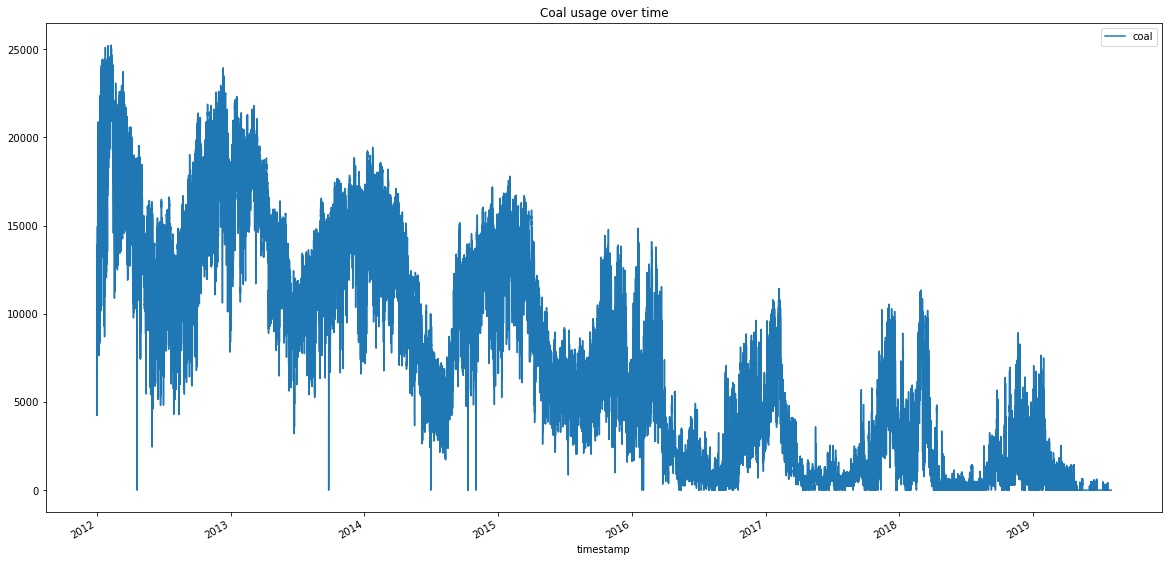

In [3]:
# Plot the coal usage column over time 
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')


Saisonalité -> usage intesif en hiver, beaucoup moins en été. Tendance à la baisse overall

In [4]:
# Pre-process coal data to get the average coal usage per day
dfDay = df
dfDay = dfDay.set_index('timestamp')
dfDay = dfDay.resample('D').mean()
dfDay = dfDay.reset_index()
print(dfDay.shape)
dfDay.head()

(2772, 2)


,timestamp,coal
0,2012-01-01,8501.128472
1,2012-01-02,10203.655052
2,2012-01-03,15384.989583
3,2012-01-04,17026.888889
4,2012-01-05,16545.250000


<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

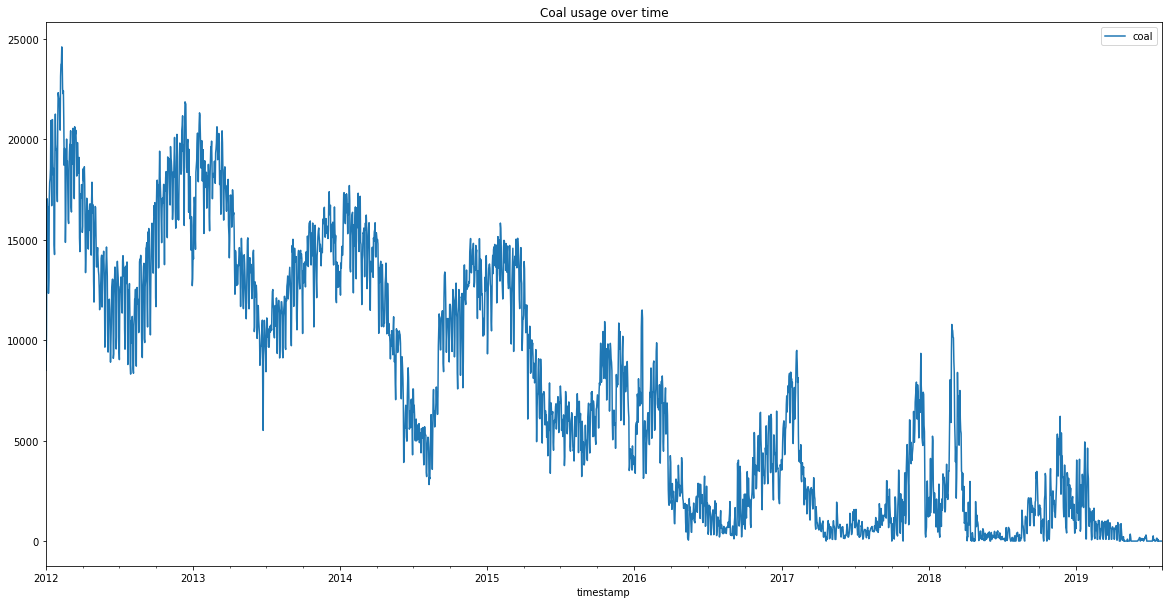

In [5]:
dfDay.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time')

<ipython-input-6-e952b473f8e9>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(dfDay['coal'], model='additive', freq=365)


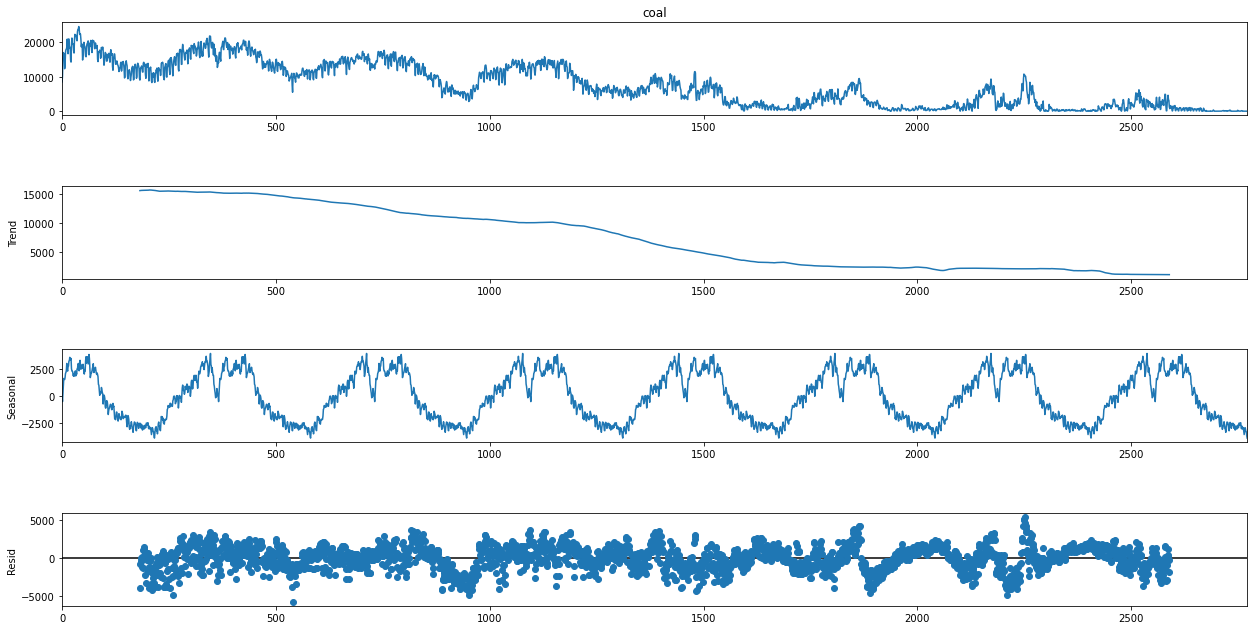

In [6]:
# Plot saisonality of coal usage over the year, the residual, and the trend
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfDay['coal'], model='additive', freq=365)

result.plot()

#Increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(20, 10)





plt.show()


On s'assure qu'on perd pas d'infos importantes en moyennant par jour

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

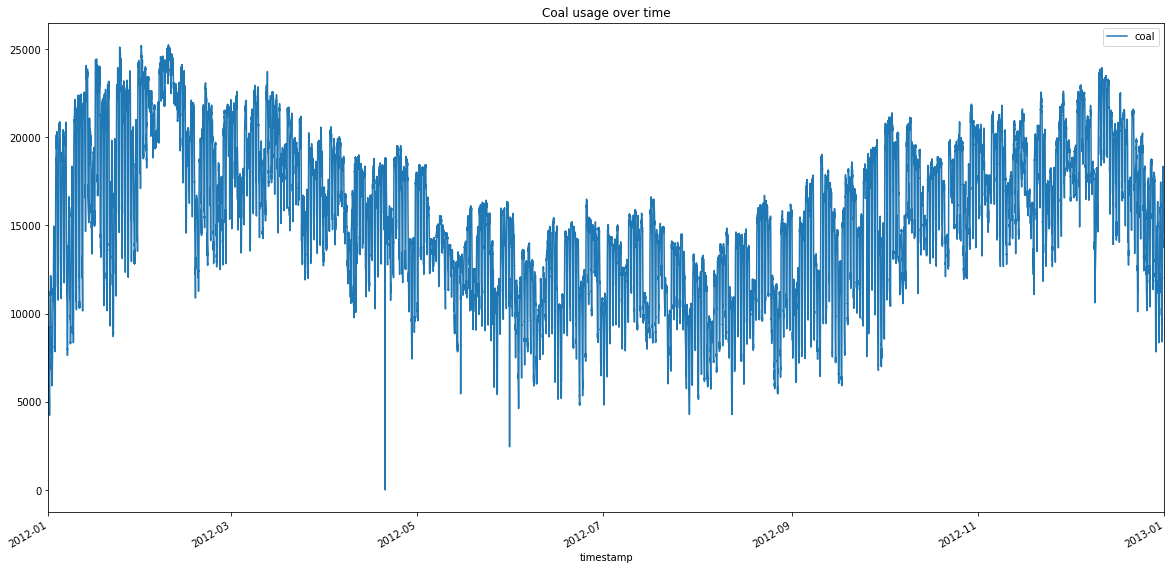

In [7]:
# Plot the first year of coal usage
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2013-01-01'])

On voit qu'il y a aussi une saisonaité journalière -> zoom sur ca

<AxesSubplot:title={'center':'Coal usage over time'}, xlabel='timestamp'>

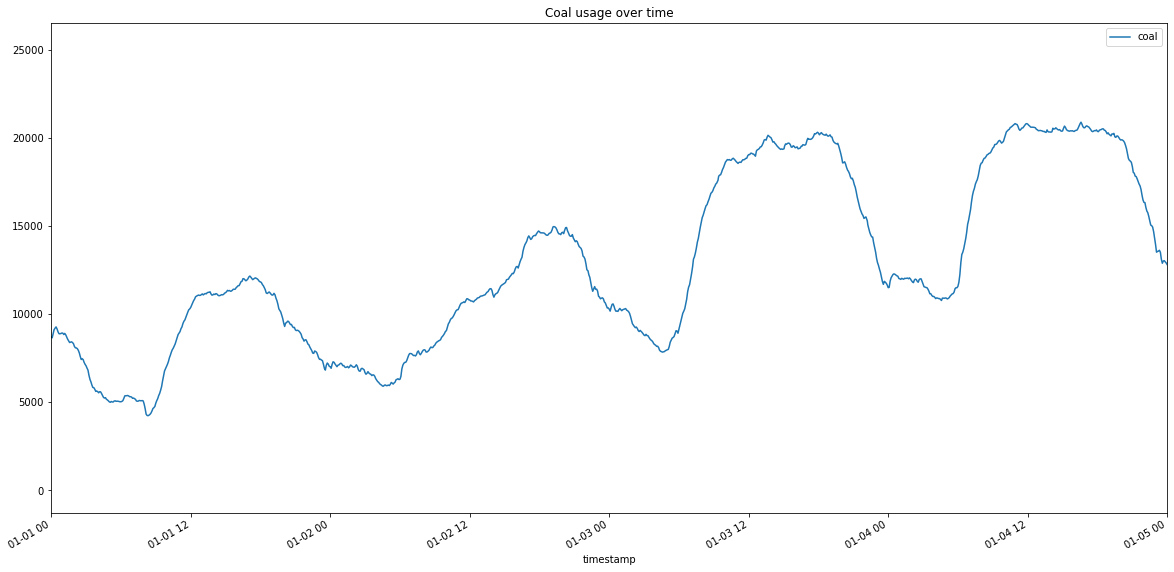

In [8]:
# Plot the first month of coal usage vs hour of day
df.plot(x='timestamp', y='coal', figsize=(20, 10), title='Coal usage over time', xlim=['2012-01-01', '2012-01-05'])


Sympa de remarquer mais surement pas très important pour l'analyse parce qu'on analyse sur des + longues périodes -> La saisonalité annuelle est plus intéressante que la saisonalité journalière, a partir d'ici pour les analyses on utilise dfDay plutot que df

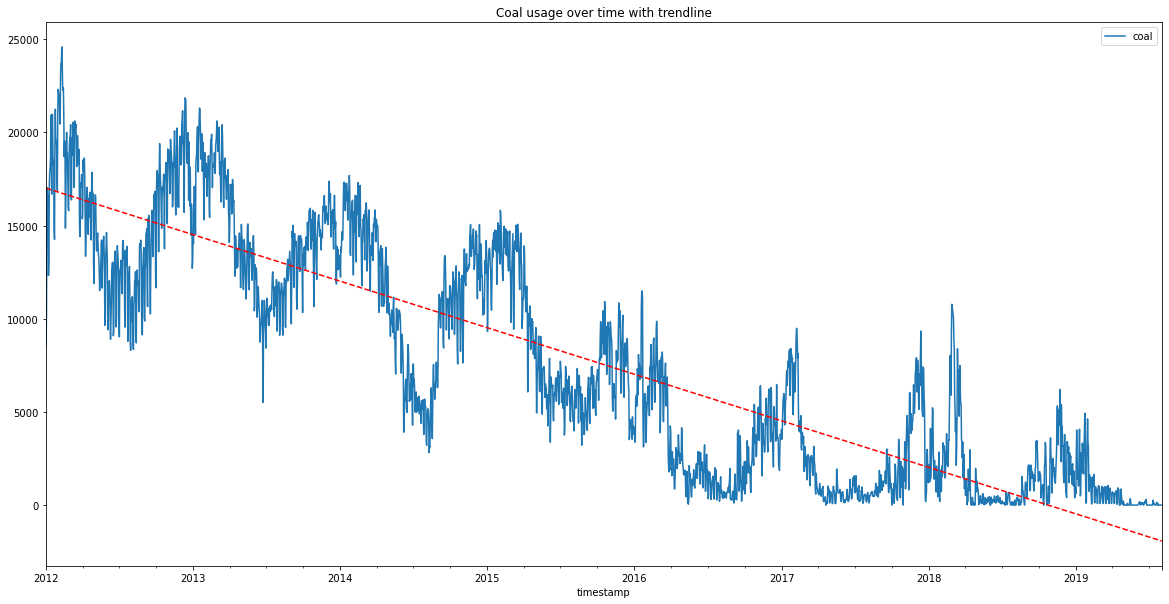

In [9]:
# Generate trendline for coal usage over time
# calc the trendline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
x = mdates.date2num(dfDay['timestamp'])
y= dfDay['coal']
z = np.polyfit(x, dfDay['coal'], 1)
p = np.poly1d(z)
#then the plot
dfDay.plot('timestamp', 'coal', figsize=(20, 10), title='Coal usage over time with trendline')
plt.plot(x, p(x), "r--")



La trendline nous indique clairement une tendance baissière (qu'on appercevait déjà à l'oeil nu mais là au moins c'est officiel)

# Cropping dataset

(1461, 2)
(1311, 2)


<ipython-input-10-65bb466a2974>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


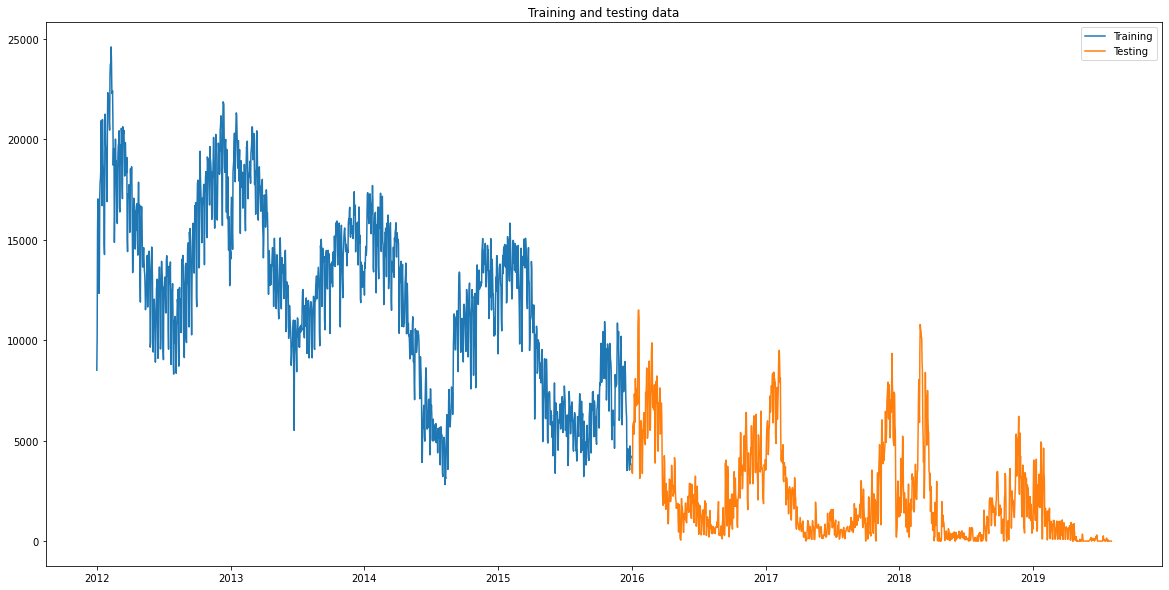

In [10]:
# Separate the dfDay dataframe into two dataframes, one for training and one for testing
dfDayTrain = dfDay[dfDay['timestamp'] < '2016-01-01']
dfDayTest = dfDay[dfDay['timestamp'] >= '2016-01-01']
print(dfDayTrain.shape)
print(dfDayTest.shape)

# Plot the training and testing dataframes with matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()

c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\jeann\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-11-618b4235f917>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


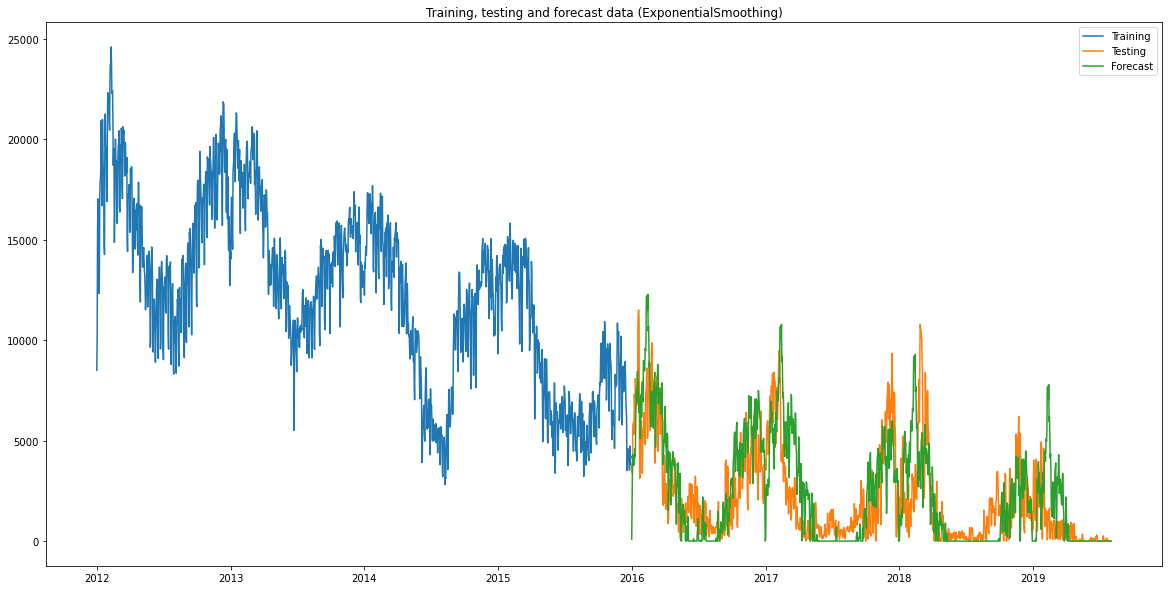

In [11]:
# We want to forecast the coal usage for the next days based on the length of the testing dataframe

from statsmodels.tsa.api import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(dfDayTrain['coal'], seasonal_periods=365, trend='add', seasonal='add').fit(optimized=True)

# Forecast the next days based on the length of the testing dataframe
forecast = model.forecast(len(dfDayTest))
# Negative values are not possible, so set them to 0
forecast[forecast < 0] = 0

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data (ExponentialSmoothing)')
ax.legend()
fig.show()




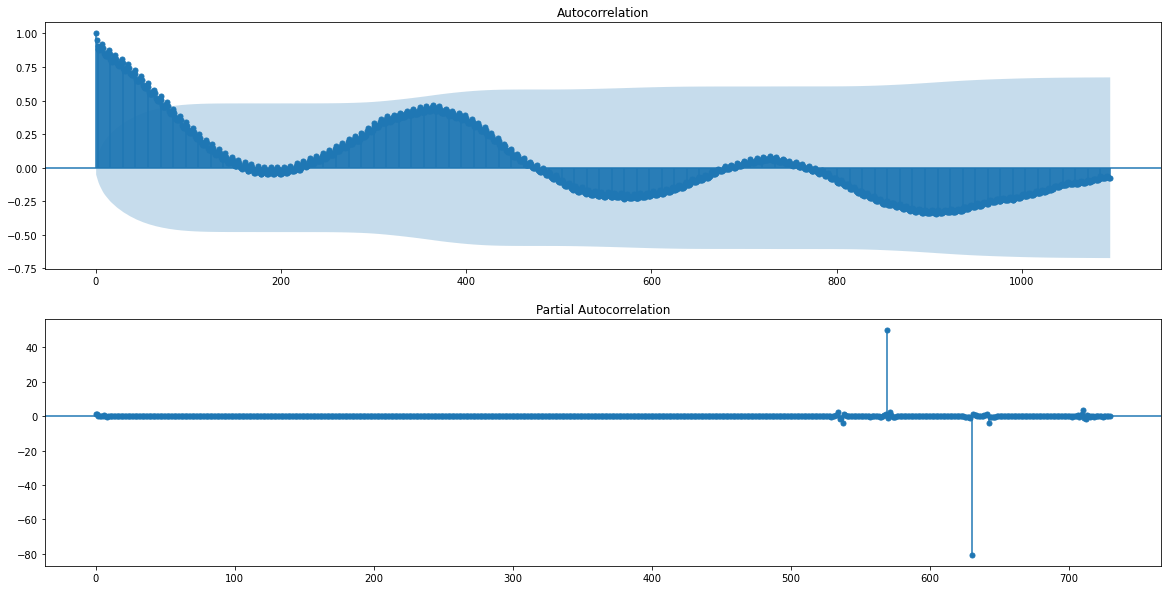

In [26]:
# Do a ACF and PACF plot to determine the order of the ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrain['coal'], lags=3*365, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrain['coal'], lags=729, ax=ax2)
plt.show()



On remarque que ce n'est pas stationnaire, on a une tendance vers le bas... On peut le savoir car ici en bas je calcule le p-value et si = 0 = stationnaire

In [13]:
# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrain['coal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -1.554461
p-value: 0.506419
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [14]:
# Diff and dropna to make the data stationary
dfDayTrainDiff = dfDayTrain.copy()
dfDayTrainDiff["coal"] = dfDayTrainDiff["coal"].diff().dropna()
dfDayTrainDiff.head()
# Drop NaN values
dfDayTrainDiff = dfDayTrainDiff.dropna()
dfDayTrainDiff.head()
print(dfDayTrainDiff.shape)


(1460, 2)


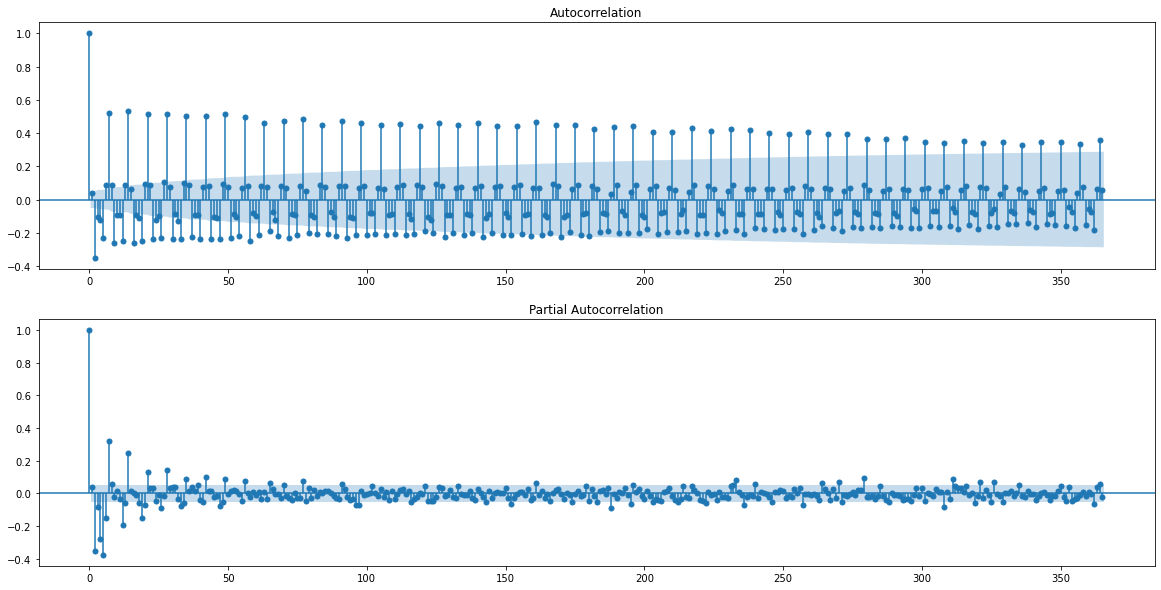

ADF Statistic: -9.580115
p-value: 0.000000


In [54]:
# Replot the ACF and PACF to determine the order of the ARIMA model
# Make two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
# Plot the ACF
plot_acf(dfDayTrainDiff["coal"], lags=365, ax=ax1)
# Plot the PACF
plot_pacf(dfDayTrainDiff["coal"], lags=365, ax=ax2)
plt.show()

# Test ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(dfDayTrainDiff["coal"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


### On voit sur le plot du haut que pour le PACF on devient dans la plage vers la 25ème et pour le ACF vers 400 ducoup j'ai déterminé p = 25 et q = 365

In [16]:
# Function to calculate the MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)



                               SARIMAX Results                                
Dep. Variable:                   coal   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12484.613
Date:                Sun, 11 Dec 2022   AIC                          24975.225
Time:                        17:08:28   BIC                          24991.084
Sample:                             0   HQIC                         24981.141
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6025      0.032     18.838      0.000       0.540       0.665
ma.L1         -0.8736      0.022    -40.255      0.000      -0.916      -0.831
sigma2      1.707e+06   5.59e+04     30.540      0.0

<ipython-input-17-b6e417f5d385>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


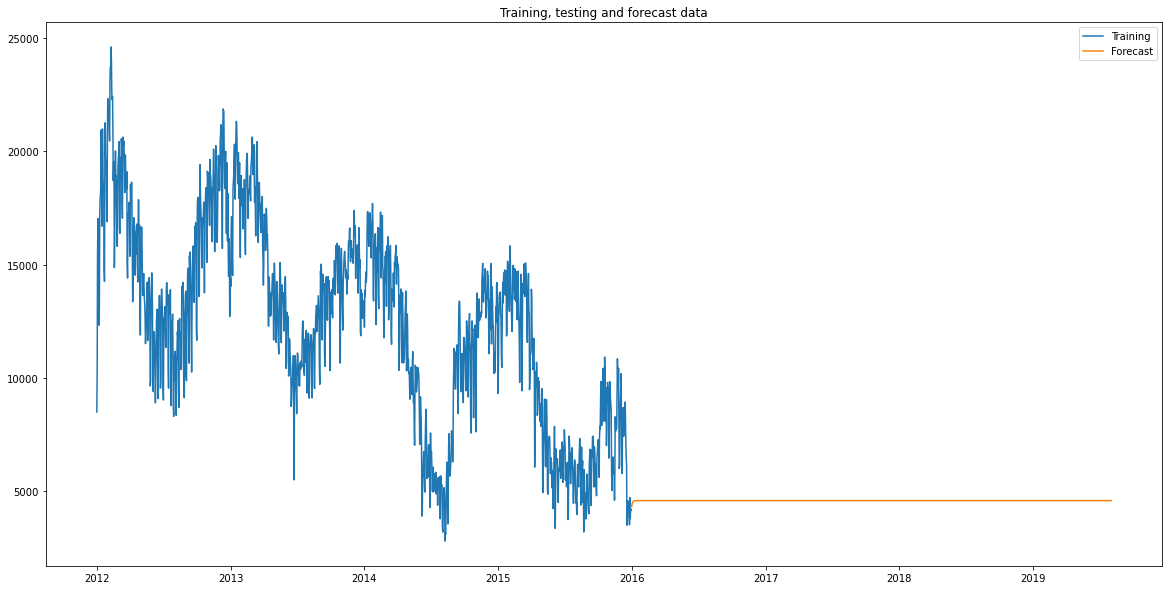

In [17]:
# Forecast the next days based on the length of the testing dataframe with ARMIA model
# Auto determine the order of the model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dfDayTrain['coal'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next days based on the length of the testing dataframe
forecast = model_fit.forecast(steps=len(dfDayTest))



#Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()

# Calculate the MSE
print(mean_squared_error(dfDayTest['coal'], forecast))


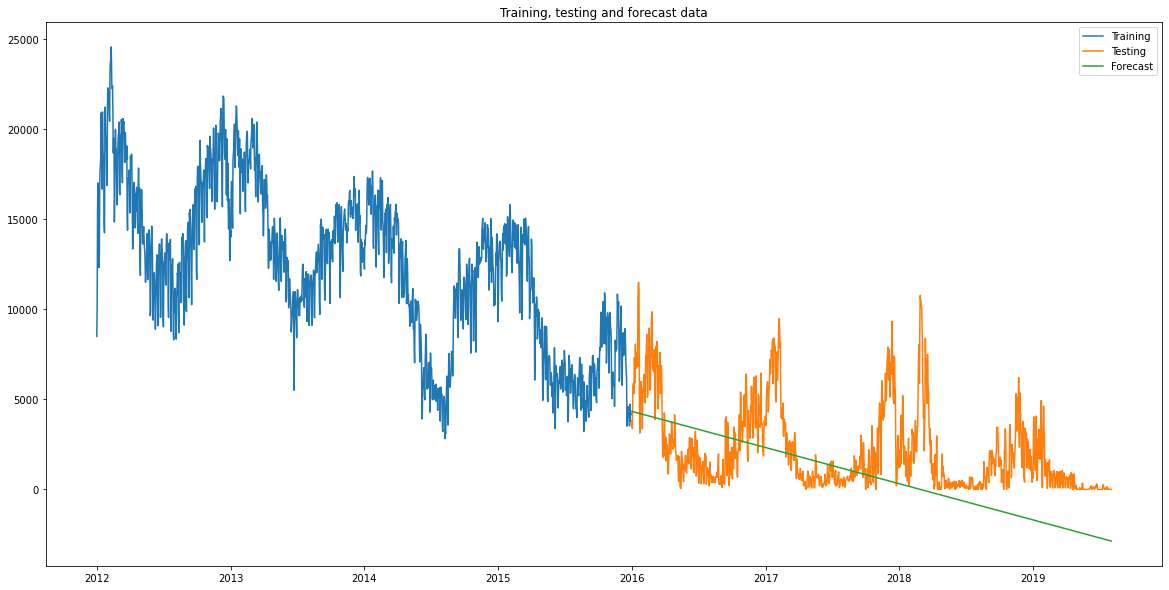

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create ARMIA model with the order (1, 1, 1) with the training data and forecast the next days based on the length of the testing dataframe
model = SARIMAX(dfDayTrain["coal"], order=(0, 2, 4))
model_fit = model.fit()
forecast = model_fit.forecast(len(dfDayTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfDayTrain['timestamp'], dfDayTrain['coal'], label='Training')
ax.plot(dfDayTest['timestamp'], dfDayTest['coal'], label='Testing')
ax.plot(dfDayTest['timestamp'], forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()



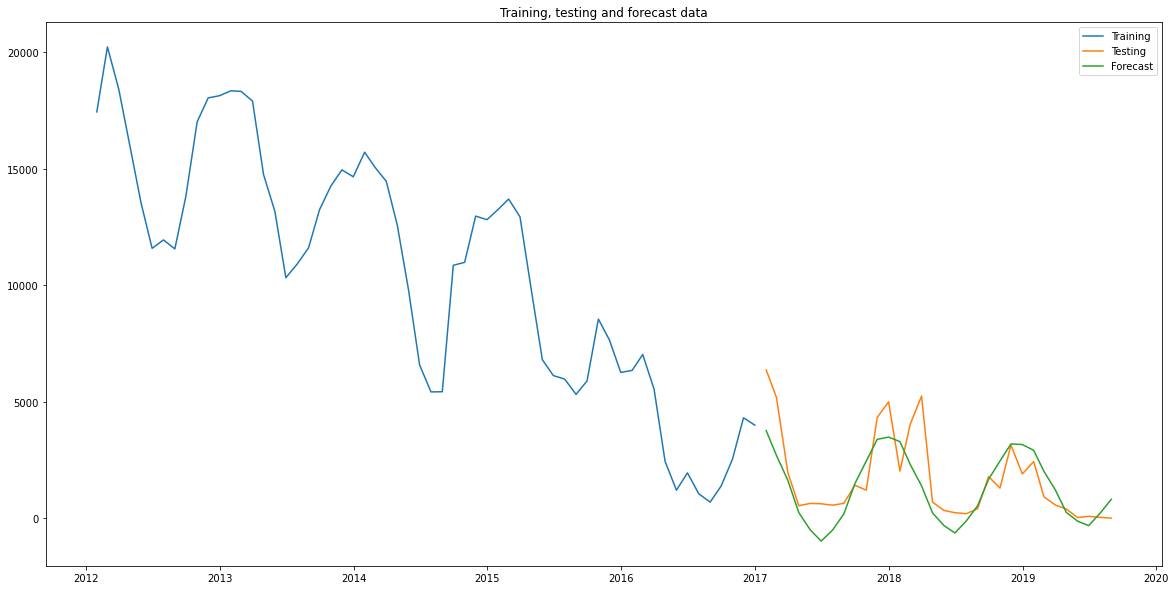

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create ARMIA model with the order (1, 1, 1) with the training data and forecast the next days based on the length of the testing dataframe
model = SARIMAX(dfMonthTrain["coal"], order=(4, 1, 3))
model_fit = model.fit()
forecast = model_fit.forecast(len(dfMonthTest))

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.plot(dfMonthTest.index, forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()


In [67]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create function who test different orders of the SARIMAX model, compare the MSE and return the best order
def evaluate_arima_model(X, arima_order):

    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    # make predictions
    # We have a seasonal component of 365 days, so we use the seasonal_order parameter
    model = SARIMAX(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))

    # calculate out of sample error
    error = mean_squared_error(test, forecast)
    return error
    
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# Evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

evaluate_models(dfMonth['coal'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=6076606.031
ARIMA(0, 0, 1) MSE=5569076.675
ARIMA(0, 0, 2) MSE=4927616.617
ARIMA(0, 0, 3) MSE=4477499.070
ARIMA(0, 0, 4) MSE=5211742.144
ARIMA(0, 1, 0) MSE=8516408.242
ARIMA(0, 1, 1) MSE=7371794.747
ARIMA(0, 1, 2) MSE=7221395.073
ARIMA(0, 1, 3) MSE=6610959.132
ARIMA(0, 1, 4) MSE=5391977.811
ARIMA(0, 2, 0) MSE=15480529.183
ARIMA(0, 2, 1) MSE=12741326.260
ARIMA(0, 2, 2) MSE=4336227.284
ARIMA(0, 2, 3) MSE=3242522.463
ARIMA(0, 2, 4) MSE=3202451.335
ARIMA(1, 0, 0) MSE=5746422.612
ARIMA(1, 0, 1) MSE=4167432.361
ARIMA(1, 0, 2) MSE=2805117.133
ARIMA(1, 0, 3) MSE=3576890.052
ARIMA(1, 0, 4) MSE=4458270.886
ARIMA(1, 1, 0) MSE=7858618.674
ARIMA(1, 1, 1) MSE=7347585.371
ARIMA(1, 1, 2) MSE=8960569.011
ARIMA(1, 1, 3) MSE=6666380.559
ARIMA(1, 1, 4) MSE=6305797.627
ARIMA(1, 2, 0) MSE=13340673.055
ARIMA(1, 2, 1) MSE=11403112.032
ARIMA(1, 2, 2) MSE=17672513.099
ARIMA(1, 2, 3) MSE=3220351.316
ARIMA(1, 2, 4) MSE=3501470.660
ARIMA(2, 0, 0) MSE=3140282.801
ARIMA(2, 0, 1) MSE=3140819.059
ARI

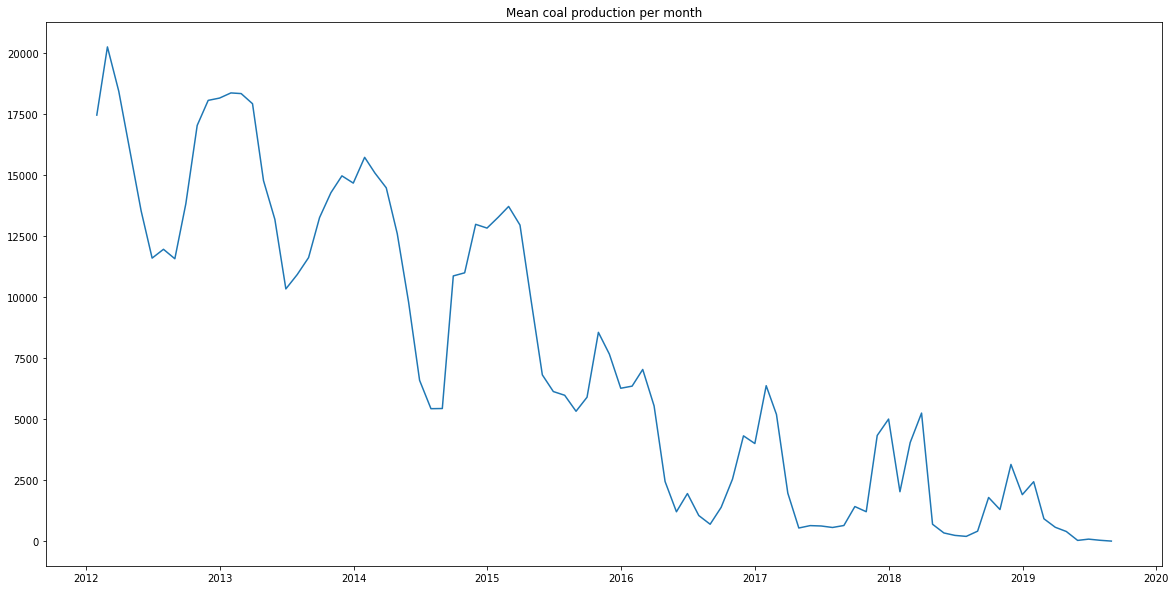

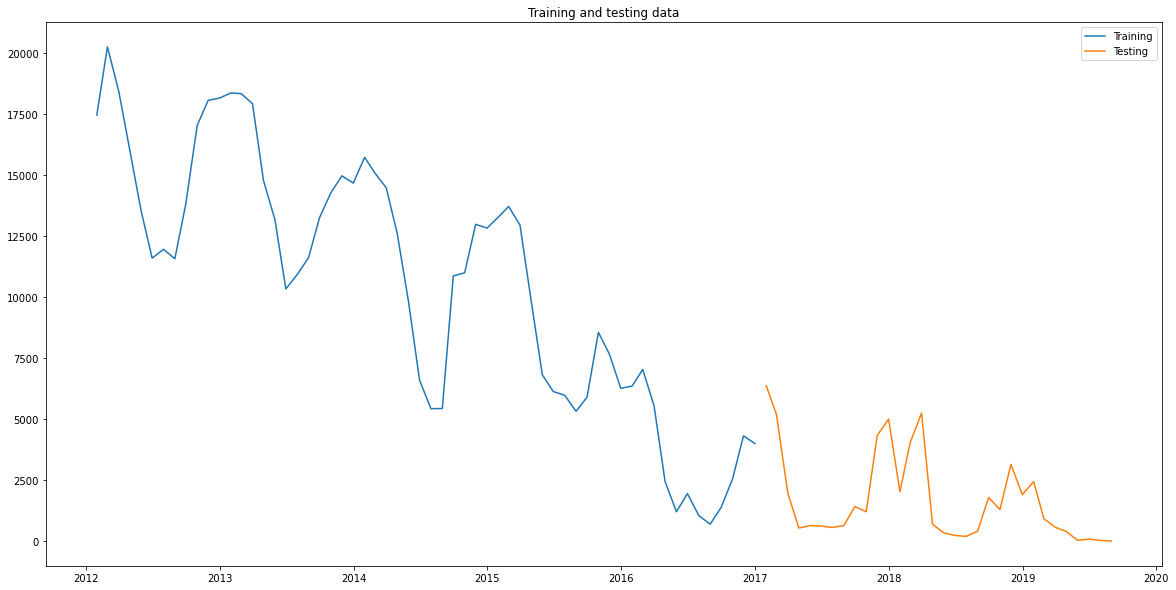

In [51]:
# Create a reduced dataframe with only the timestamp and the coal column
dfMonth = dfDay[['timestamp', 'coal']].copy()

# Mean of the coal column per month
dfMonth = dfMonth.groupby(pd.Grouper(key='timestamp', freq='M')).mean()
dfMonth.head()

# Plot the data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonth.index, dfMonth['coal'])
ax.set_title('Mean coal production per month')
fig.show()

# Split the data in training and testing data
dfMonthTrain = dfMonth[:'2016-12-31']
dfMonthTest = dfMonth['2017-01-31':]

# Plot the training and testing data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.set_title('Training and testing data')
ax.legend()
fig.show()



                                      SARIMAX Results                                       
Dep. Variable:                                 coal   No. Observations:                   60
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 12)   Log Likelihood                -519.519
Date:                              Sun, 11 Dec 2022   AIC                           1051.039
Time:                                      18:08:31   BIC                           1063.605
Sample:                                  01-31-2012   HQIC                          1055.954
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9648      0.024     40.392      0.000       0.918       1.012
ar.S.L12      -0.26

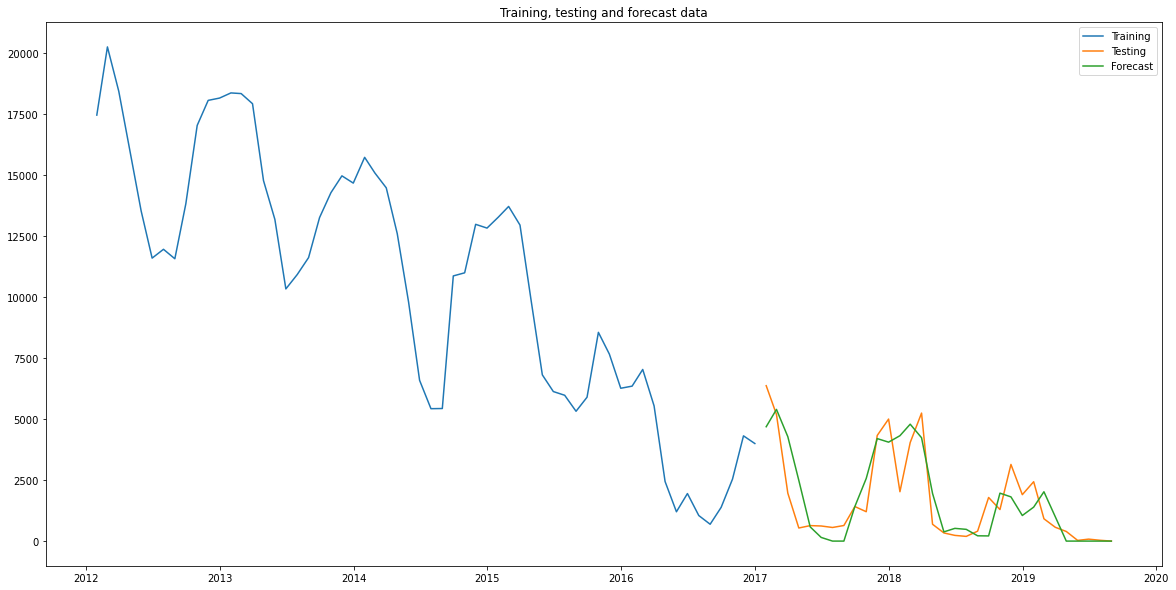

In [66]:
# SARIMA model with the order (1, 1, 1) and seasonal order (1, 1, 1, 12)
model = SARIMAX(dfMonthTrain['coal'], seasonal_order=(3, 0, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

# Forecast the next months based on the length of the testing dataframe
# Negative values are not possible, if the forecast is negative, we set it to 0
forecast = model_fit.forecast(len(dfMonthTest))
forecast = [0 if x < 0 else x for x in forecast]



# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.plot(dfMonthTest.index, forecast, label='Forecast')
ax.set_title('Training, testing and forecast data')
ax.legend()
fig.show()





In [65]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create function who test different orders of the SARIMAX model, compare the MSE and return the best order
def evaluate_arima_model(X, arima_order, train, test):
    # make predictions
    # We have a seasonal component of 365 days, so we use the seasonal_order parameter
    model = SARIMAX(train, order=arima_order, seasonal_order=(arima_order[0], arima_order[1], arima_order[2], 12))
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))

    # calculate out of sample error
    error = mean_squared_error(test, forecast)
    return error
    
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, train, test):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order, train, test)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    #print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))

# Evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Remove warnings
import warnings
warnings.filterwarnings("ignore")
evaluate_models(dfMonth['coal'].values, p_values, d_values, q_values, dfMonthTrain['coal'], dfMonthTest['coal'])


Best ARIMA (3, 0, 1) MSE=1031731.743


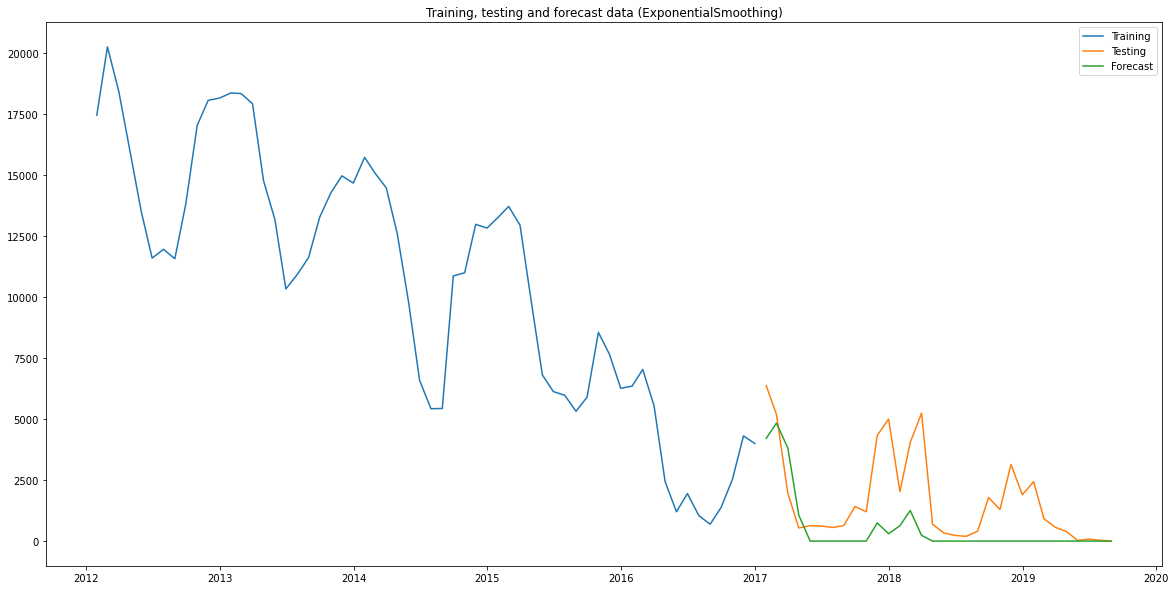

In [28]:
# We want to forecast the coal usage for the next days based on the length of the testing dataframe

from statsmodels.tsa.api import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(dfMonthTrain['coal'], seasonal_periods=12, trend='add', seasonal='add').fit(optimized=True)

# Forecast the next days based on the length of the testing dataframe
forecast = model.forecast(len(dfMonthTest))
# Negative values are not possible, so set them to 0
forecast[forecast < 0] = 0

# Plot the forecast
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dfMonthTrain.index, dfMonthTrain['coal'], label='Training')
ax.plot(dfMonthTest.index, dfMonthTest['coal'], label='Testing')
ax.plot(dfMonthTest.index, forecast, label='Forecast')
ax.set_title('Training, testing and forecast data (ExponentialSmoothing)')
ax.legend()
fig.show()


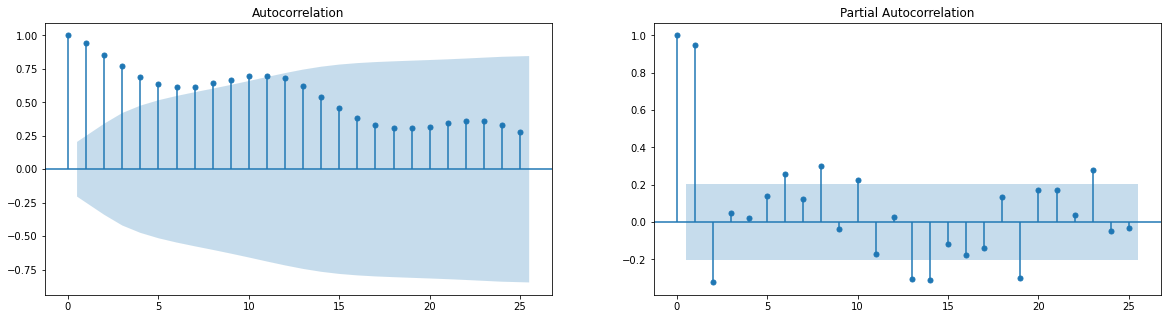

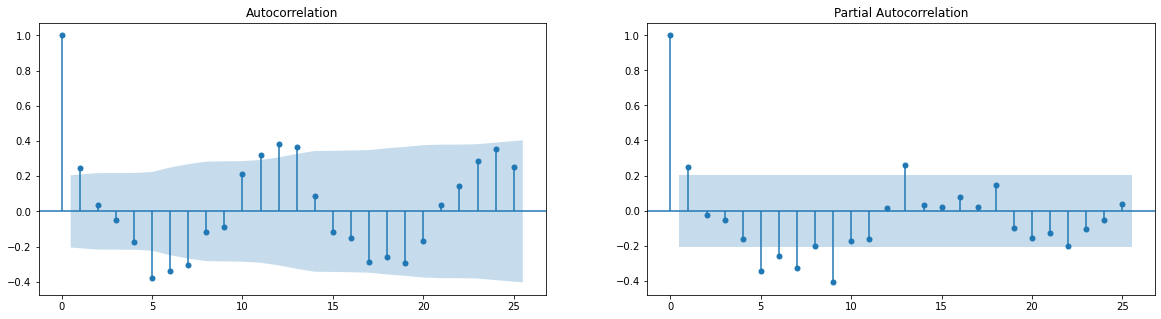

In [31]:
# PACF and ACF plots of the dataset dfMonth
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(dfMonth['coal'], lags=25, ax=ax[0])
plot_pacf(dfMonth['coal'], lags=25, ax=ax[1])
fig.show()

dfMonthStationary = dfMonth.diff().dropna().copy()
dfMonthStationary.head()

# PACF and ACF plots of the stationary dataset dfMonthStationary
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(dfMonthStationary['coal'], lags=25, ax=ax[0])
plot_pacf(dfMonthStationary['coal'], lags=25, ax=ax[1])
fig.show()

